## ch03. 평가

#### - 분류의 성능 평가 지표 : 정확도, 오차행렬, 정밀도, 재현율, F1 스코어, ROC AUC

### 01. 정확도

#### : 실제 데이터에서 예측 데이터가 얼마나 같은지 판단하는 지표

In [1]:
# 라이브러리 로드
from sklearn.base import BaseEstimator
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# 전처리 함수 정의
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 불필요한 속성 제거 함수
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩
def format_features(df):
    df['Cabin']=df['Cabin'].str[:1] # Carbin값의 첫번째 문자만 가져옴
    features=['Cabin','Sex','Embarked']
    for feature in features:
        le=LabelEncoder()
        le=le.fit(df[feature])
        df[feature]=le.transform(df[feature])
    return df

# 전처리 함수 호출
def transform_features(df):
    df=fillna(df)
    df=drop_features(df)
    df=format_features(df)
    return df

In [3]:
# 분류 클래스
class MyDummyClassifier(BaseEstimator):
    # fit 메서드는 아무것도 학습하지 않음
    def fit(self,X,y=None):
        pass
    # sex 피처가 1이면 0, 그렇지 않으면 1로 예측
    def predict(self,X):
        pred=np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] ==1:
                pred[i]=0
            else:
                pred[i]=1

        return pred

In [4]:
# 데이터 로딩, 가공, 테스트/학습 데이터 분리
df = pd.read_csv('titanic_train.csv')
y_df = df['Survived']
X_df = df.drop('Survived',axis=1)
X_df = transform_features(X_df)
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=1)

# Dummy Classifier 사용하여 학습/예측/평가
myclf=MyDummyClassifier()
myclf.fit(X_train,y_train)

mypredictions = myclf.predict(X_test)
print('정확도: {0:.4f}'.format(accuracy_score(y_test,mypredictions)))

정확도: 0.7765


#### => 단순한 알고리즘으로 예측하더라도 정확도가 비교적 높게 측정
#### => 정확도를 평가지표로 사용할 때는 매우 신중해야 함.

In [5]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
    
digits = load_digits()

y = (digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=1)

print('레이블 테스트 셋 크기:',y_test.shape)
print('테스트 셋 레이블 0과 1 분포')
print(pd.Series(y_test).value_counts())

fakeclf = MyFakeClassifier()
fakeclf.fit(X_train,y_train)
fakepred = fakeclf.predict(X_test)
print("모든예측을 0으로 하였을 때 정확도 : {0:.3f}".format(accuracy_score(y_test,fakepred)))


레이블 테스트 셋 크기: (450,)
테스트 셋 레이블 0과 1 분포
0    402
1     48
dtype: int64
모든예측을 0으로 하였을 때 정확도 : 0.893


#### >> 단순히 모두 0 값으로 반환함에도 정확도가 약 90%임
#### >>> 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용되어서는 안됨.

### 02. 오차행렬

#### : 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[402,   0],
       [ 48,   0]], dtype=int64)

![](img/cm.png)

#### - TP, TN, FP, FN 값은 Classifier 성능의 여러 면모를 판단할 수 있는 기반 정보 제공
#### - 이 값을 조합해 정확도, 정밀도, 재현율 값 알 수 있음

#### 정확도 = 결과와 실제가 동일한 건수 / 전체 데이터 수
      = (TN + TP) / (TN + TF + PN + PF)

### 03. 정밀도와 재현율 

#### : Positive 데이터 세트의 예특 성능에 좀 더 초점을 맞춘 평가 지표

- 정밀도 : TP / (FP+TP) , 
    - 예측을 positive로 한 대상 중에 예측과 실제값이 positive로 일치한 데이터의 비율
    - Positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표 = 양성 예측도
    - **재현율이 중요한 경우** : positive를 negative로 잘못 판단하면 큰 영향이 발생하는 경우
    
    
- 재현율(민감도, TPR) : TP / (FN+TP) 
    - 실제 값이 positive인 대상 중에 예측과 실제 값이 positive로 일치한 데이터의 비율
    - **정밀도가 중요한 경우** : negative를 positive로 잘못 판단하면 큰 영향이 발생하는 경우

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    # f1 score 추가
    f1 = f1_score(y_test,pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {0:.4f}, 재현율: {0:.4f}, F1 : {0:.4f}'.format(accuracy,precision,recall,f1))

In [32]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


df = pd.read_csv('titanic_train.csv')
y_df = df['Survived']
X_df = df.drop('Survived',axis=1)
X_df = transform_features(X_df)
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
get_clf_eval(y_test,lr_pred)

오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.8492, 재현율: 0.8492, F1 : 0.8492


C:\Users\qkral\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- **정밀도/재현율 트레이드 오프** : 서로 상호보완적인 평가지표이기 때문에 한쪽을 강제로 높이면 다른 하나의 수치는 떨어짐

In [33]:
# pred_proba() : 개별 데이터별로 예측 확률을 반환하는 메서드
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 shape : {0}'.format(pred_proba.shape))
print('pred_proba array 앞 3개만 추출 : \n',pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합해 한눈에 확인
pred_proba_result = np.concatenate([pred_proba,pred.reshape(-1,1)],axis=1)
print('두 개의  class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba() 결과 shape : (179, 2)
pred_proba array 앞 3개만 추출 : 
 [[0.46161106 0.53838894]
 [0.87862428 0.12137572]
 [0.87719471 0.12280529]]
두 개의  class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46161106 0.53838894 1.        ]
 [0.87862428 0.12137572 0.        ]
 [0.87719471 0.12280529 0.        ]]


- binarizer : threshold 값보다 크면 1, 작으면 0 반환 => pred()는 Pred_proba() 기반으로 생성된 API

In [34]:
from sklearn.preprocessing import Binarizer

# 테스트를 수행할 모든 임곗값
thresholds = [0.4,0.45,0.5,0.55,0.6]

# 임계값에 따른 정확도, 정밀도, 재현율 구하기 위한 함수
def get_eval_by_threshold(y_test,pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test,custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.8380, 재현율: 0.8380, F1 : 0.8380
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.8492, 재현율: 0.8492, F1 : 0.8492
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.8492, 재현율: 0.8492, F1 : 0.8492
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8659, 재현율: 0.8659, F1 : 0.8659
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8771, 재현율: 0.8771, F1 : 0.8771


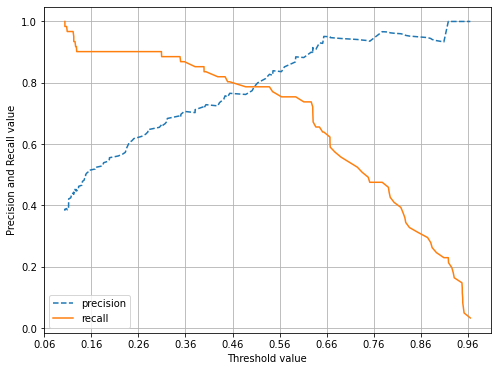

In [35]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# precision_recall_curve 사용하여 정확도, 재현율, 정밀도 그래프로 나타내는 함수
def precision_recall_curve_plot(y_test,pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary],linestyle='--',label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

- 임곗값이 낮을수록 많은 수의 양성 예측으로 인해 재현값이 극도로 높아짐
- 임곗값을 계속 증가시키면 재현율이 낮아지고 정밀도가 높아짐
- 두 수치 중 하나만 강조하는 상황이 돼서는 안됨.
- 임곗값은 업무 환경에 맞게 **상호 보완할 수 있는 수준에서 적용**되어야 함.

### 04. F1 스코어

#### : 정밀도와 재현율을 결합한 지표
- 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐.

![](img/f1.jpg)

In [36]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test,pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,f1_score

def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    # f1 score 추가
    f1 = f1_score(y_test,pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {0:.4f}, 재현율: {0:.4f}, F1 : {0:.4f}'.format(accuracy,precision,recall,f1))

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.8380, 재현율: 0.8380, F1 : 0.8380
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.8492, 재현율: 0.8492, F1 : 0.8492
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.8492, 재현율: 0.8492, F1 : 0.8492
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8659, 재현율: 0.8659, F1 : 0.8659
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8771, 재현율: 0.8771, F1 : 0.8771


### ROC 곡선과 AUC

#### : 수신자 판단 곡선,  이진분류 모델의 예측 성능 판단하는 중요한 평가 지표
- ROC 곡선 : FPR(X축)이 변할 때 TPR(Y축)이 어떻게 변하는지 나타내는 곡선
    - TPR : 재현율 = 민감도, positive가 정확히 예측되어야 하는 수준
    - TNR : 특이성, 민감도에 대응하는 지표, negative가 정확히 예측되어야 하는 수준
    - **FPR = FP / (FP+TN) = 1 - TNR**
    
    
- AUC ( Area Under Curve) : ROC 곡선 밑의 면적을 구한 것
    - 1에 가까울수록 좋은 수치

In [38]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# fpr, tpr, 임계값 구하기
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 단계로 추출
# thresholds[0]은 max(예측확률)+1 로 임의 설정됨. 이를 제외하기 위해 1부터 시작
thr_idx = np.arange(1, thresholds.shape[0],5)

print('임곗값 배열 인덱스 : ', thr_idx)
print('샘플 인덱스로 추출한 임곗값: ',np.round(thresholds[thr_idx],2))

print('FPR : ',np.round(fprs[thr_idx],3))
print('TPR : ',np.round(tprs[thr_idx],3))

임곗값 배열 인덱스 :  [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 인덱스로 추출한 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
FPR :  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
TPR :  [0.033 0.639 0.705 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


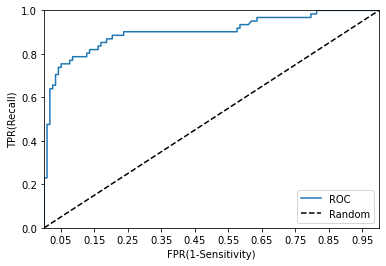

In [39]:
# ROC 곡선으로 시각화

def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # 그래프
    plt.plot(fprs,tprs,label='ROC')
    # 가운데 대각선 직선
    plt.plot([0,1],[0,1],'k--',label='Random')
    
    # FPR 축의 Scale을 0.1 단위로 변경, 축 명 설정
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1);plt.ylim(0,1)
    plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

In [40]:
# AUC
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test,pred_proba)
print('roc auc 값: {0:.4f}'.format(roc_score) )

roc auc 값: 0.9023


In [41]:
# 최종 평가 지표 함수

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,f1_score,roc_auc_score

def get_clf_eval(y_test,pred,pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    # f1 score 추가
    f1 = f1_score(y_test,pred)
    # ROC_AUC 추가
    roc_auc = roc_auc_score(y_test,pred_proba) 
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {0:.4f}, 재현율: {0:.4f}, F1 : {0:.4f}, AUC : {0:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

In [44]:
get_clf_eval(y_test,pred,pred_proba)

오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.8492, 재현율: 0.8492, F1 : 0.8492, AUC : 0.8492
